In [1]:
import os
import sys


import matplotlib.pyplot as plt

# Import utility functions
from gnn_utils import (
    setup_matplotlib_style,
    load_data,
    preprocess_data,
    identify_target_indexes,
    truncate_data,
    prepare_gnn_data,
    run_loocv_utility,
    summarize_loocv_results,
    plot_loocv_predictions,
    calculate_cycles_from_timesteps,
)

# Set default parameters for Jupyter notebook
stiffness_path = 'Data/Stiffness_Reduction'
strain_path = 'Data/Strain'
num_nodes = 16
batch_size = 128
hidden_dim = 64
num_gnn_layers = 4
dropout = 0.5
genconv_aggr = 'add'
epochs = 1000
patience = 20
optimizer = 'adamw'
weight_decay = 0.01
drop_level = 85
visualize = True
save_plots = False
output_dir = 'results'


# Create directories if they don't exist
os.makedirs('best_model', exist_ok=True)
os.makedirs('log', exist_ok=True)
if save_plots:
    os.makedirs(output_dir, exist_ok=True)

# Load data
print("Loading data...")
stiffness_dfs, strain_dfs = load_data(stiffness_path, strain_path)

# Preprocess data
print("\nPreprocessing data...")
stiffness_post, strain_post, last_cycle = preprocess_data(stiffness_dfs, strain_dfs)


strain_post_cycles = calculate_cycles_from_timesteps(strain_post, stiffness_post, last_cycle)

Loading data...
Loaded 5 stiffness datasets.
Loaded 5 strain datasets.

Preprocessing data...
Processing df0...
  Finished df0. Strain shape: (696, 6), Stiffness shape: (696, 1)
Processing df1...
  Finished df1. Strain shape: (739, 16), Stiffness shape: (739, 1)
Processing df2...
  Adjusted df2 strain shape: (186405, 16)
  Finished df2. Strain shape: (770, 16), Stiffness shape: (770, 1)
Processing df3...
  Finished df3. Strain shape: (768, 16), Stiffness shape: (768, 1)
Processing df4...
  Finished df4. Strain shape: (719, 16), Stiffness shape: (719, 1)

Preprocessing complete.


In [2]:
last_cycle

{'df0': 3273, 'df1': 3060, 'df2': 3336, 'df3': 3144, 'df4': 3233}

In [2]:
strain_post_cycles


{'df0': Index([ 5.122327721562517,   9.82430998383365, 14.526292246104783,
        19.228274508375915,  23.93025677064705, 28.632239032918182,
        33.334221295189316, 38.036203557460446, 42.738185819731584,
        47.440168082002714,
        ...
          3230.68215963956, 3235.3841419018313, 3240.0861241641023,
        3244.7881064263734, 3249.4900886886444, 3254.1920709509154,
         3258.894053213187,  3263.596035475458,  3268.298017737729,
                    3273.0],
       dtype='float64', name='Time', length=696),
 'df1': Index([ 4.151000271976759,  8.291717073776248,  12.43243387557574,
        16.573150677375228,  20.71386747917472, 24.854584280974205,
        28.995301082773697, 33.136017884573185,  37.27673468637268,
         41.41745148817217,
        ...
        3022.7335487838045,  3026.874265585604, 3031.0149823874035,
         3035.155699189203, 3039.2964159910025,  3043.437132792802,
        3047.5778495946015,  3051.718566396401, 3055.8592831982005,
           

Saved data for df0 to results/df0_strain_data.csv
Saved data for df1 to results/df1_strain_data.csv
Saved data for df2 to results/df2_strain_data.csv
Saved data for df3 to results/df3_strain_data.csv
Saved data for df4 to results/df4_strain_data.csv


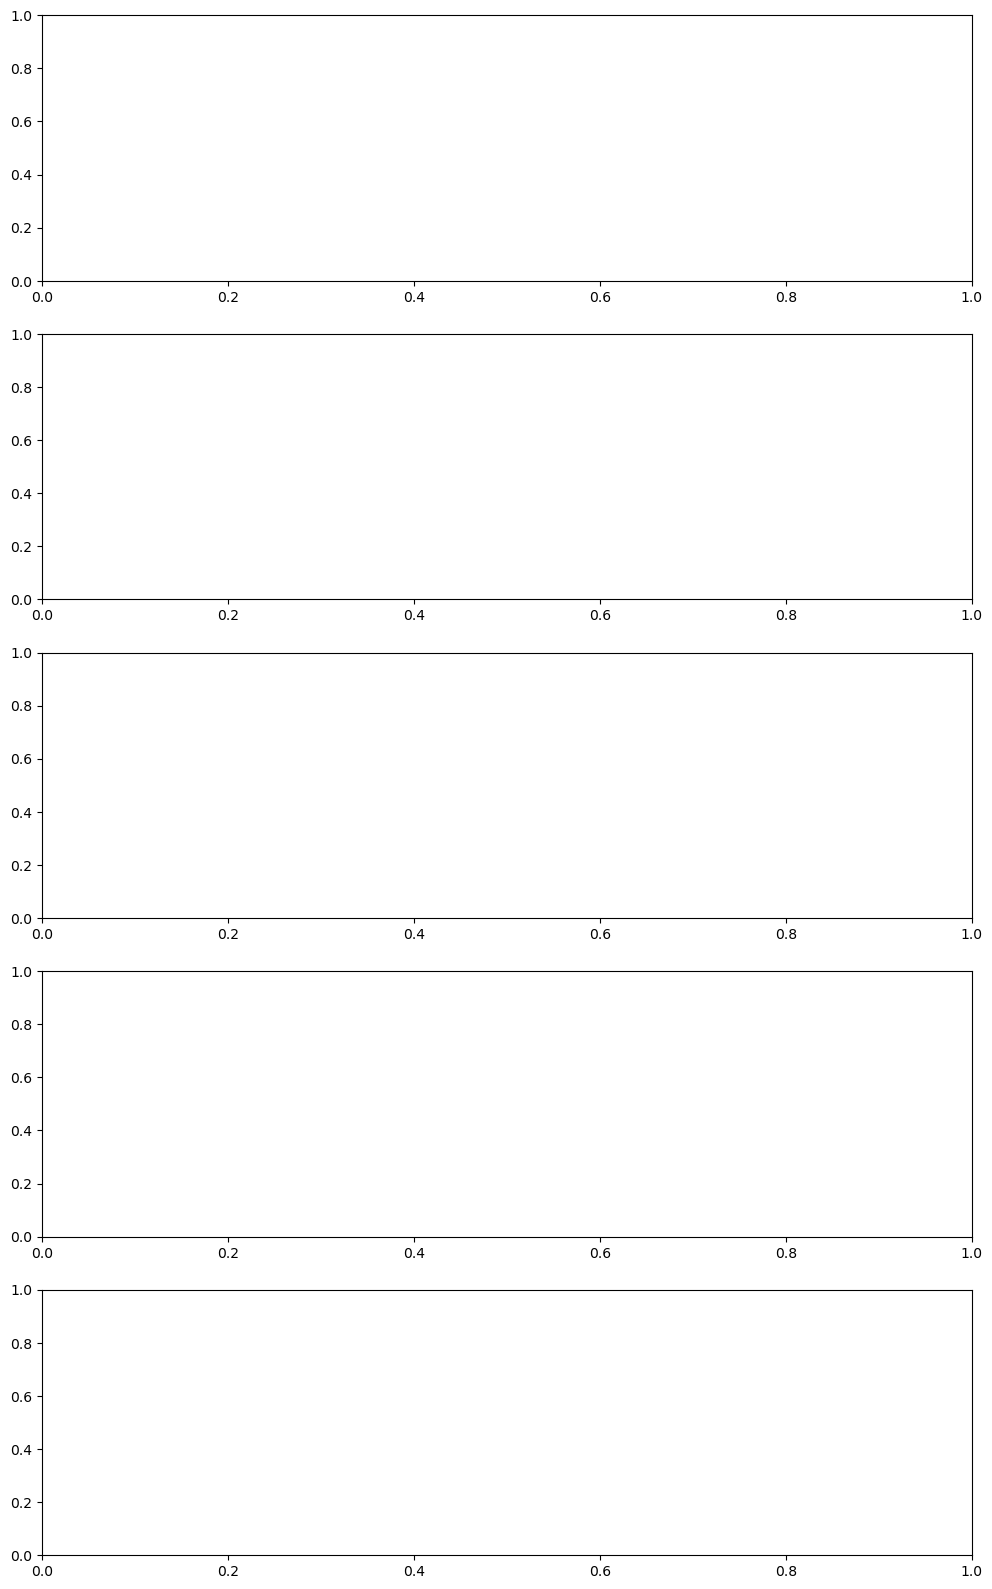

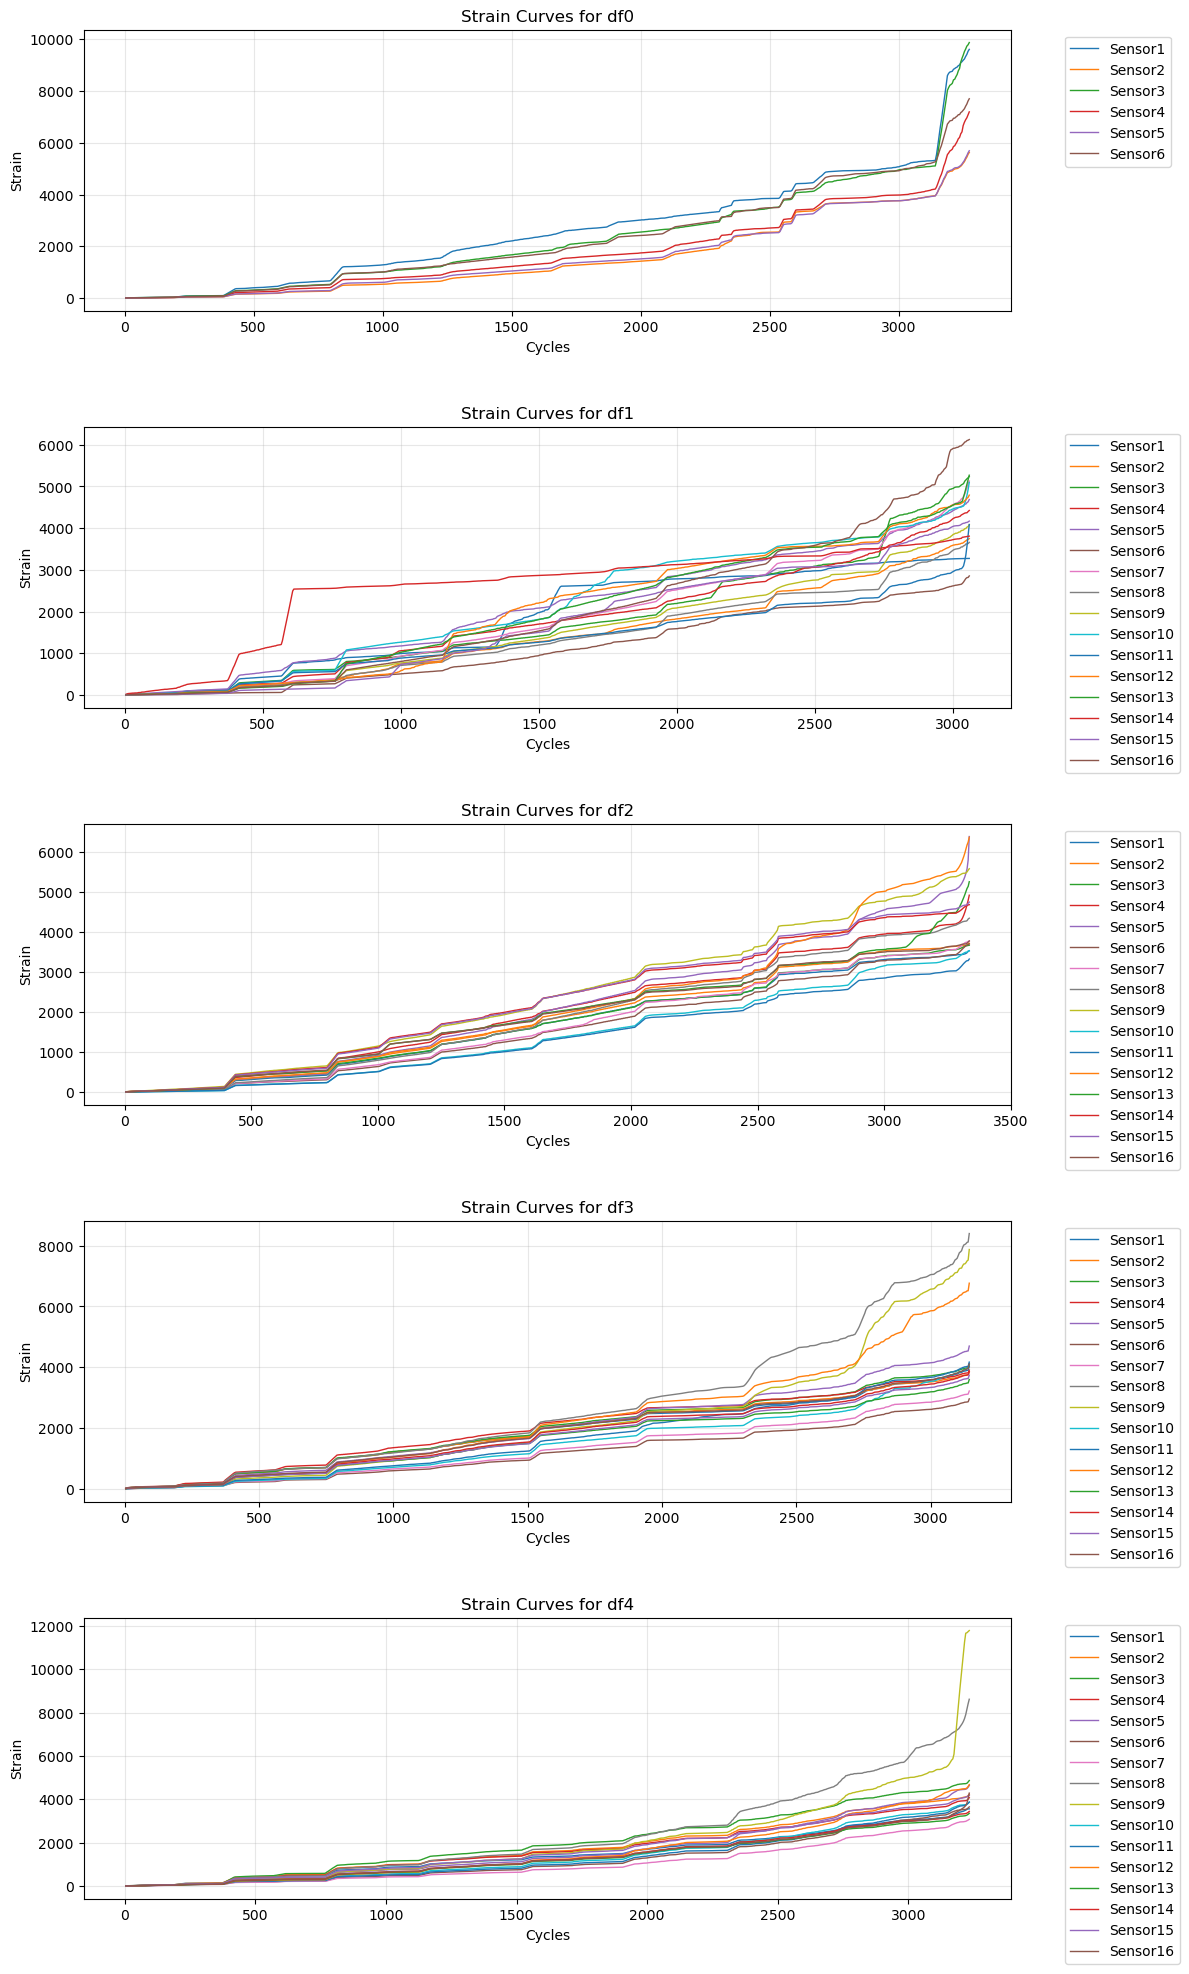

In [4]:
def plot_strain_curves(cycles, strain_dfs, save_plots=False, output_dir='results'):
    """
    Plot strain curves for each dataframe, showing all sensors in the same plot.
    Also save the data to CSV files.
    
    Parameters:
    cycles: dict of cycle data for each dataframe
    strain_dfs: dict of DataFrames with strain data
    save_plots: bool, whether to save plots
    output_dir: str, directory to save plots and CSV files
    """
    n_dfs = len(strain_dfs)
    fig, axes = plt.subplots(n_dfs, 1, figsize=(12, 4 * n_dfs))
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    n_dfs = len(strain_dfs)
    fig, axes = plt.subplots(n_dfs, 1, figsize=(12, 4 * n_dfs))
    if n_dfs == 1:
        axes = [axes]
    
    for i, (df_name, df) in enumerate(strain_dfs.items()):
        ax = axes[i]
        
        # Plot all sensor columns
        for column in df.columns:
            if 'Sensor' in column:
                ax.plot(cycles[df_name], df[column], label=column, linewidth=1)
        
        ax.set_title(f'Strain Curves for {df_name}')
        ax.set_xlabel('Cycles')
        ax.set_ylabel('Strain')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # Save data to CSV
        csv_data = pd.DataFrame()
        csv_data['Cycles'] = cycles[df_name]
        
        # Add sensor columns with proper naming
        sensor_columns = [col for col in df.columns if 'Sensor' in col]
        for j, column in enumerate(sensor_columns):
            csv_data[f'Sensor {j}'] = df[column].values
        
        # Save to CSV
        csv_filename = f'{output_dir}/{df_name}_strain_data.csv'
        csv_data.to_csv(csv_filename, index=False)
        print(f"Saved data for {df_name} to {csv_filename}")
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'{output_dir}/strain_curves_all.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# Call the function
plot_strain_curves(strain_post_cycles, strain_post, save_plots, output_dir)